In [1]:
import json
import os
from concurrent.futures import ThreadPoolExecutor
from copy import deepcopy
from typing import List, Tuple

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow import keras
from typing_extensions import TypedDict

In [2]:
IMAGE_SIZE = (512, 512)
TEST_RATIO = 0.2

In [3]:
class GeometricFigure(TypedDict):
    id: int
    category: str
    is_failed: bool
    filename: str
    image: np.ndarray


class GeometricFigureFromJSON(TypedDict):
    id: int
    type: str
    isFailed: bool
    filename: str

In [4]:
def load_image(path: str) -> np.ndarray:
    img = Image.open(path)
    img = img.resize(IMAGE_SIZE)
    img = np.array(img, dtype=float)/255
    return img


def get_filenames_from_directory(path: str) -> list:
    return [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]


def process_geometric_figure(geometric_figure: dict):
    return {
        'id': geometric_figure['id'],
        'category': geometric_figure['type'],
        'is_failed': geometric_figure['isFailed'],
        'filename': geometric_figure['filename'],
        'image': load_image(os.path.join('data', 'Geometric Figures', geometric_figure['filename']))
    }


def get_geometric_figures(path: str) -> List[GeometricFigure]:
    with open(path, 'r') as f:
        content = f.read()
    data: List[GeometricFigureFromJSON] = json.loads(content)
    with ThreadPoolExecutor() as executor:
        geometric_figures = list(executor.map(process_geometric_figure, data))
    return geometric_figures


geometric_figures: List[GeometricFigure] = get_geometric_figures('data/data.json')
print(f'Loaded {len(geometric_figures)} geometric figures')

Loaded 660 geometric figures


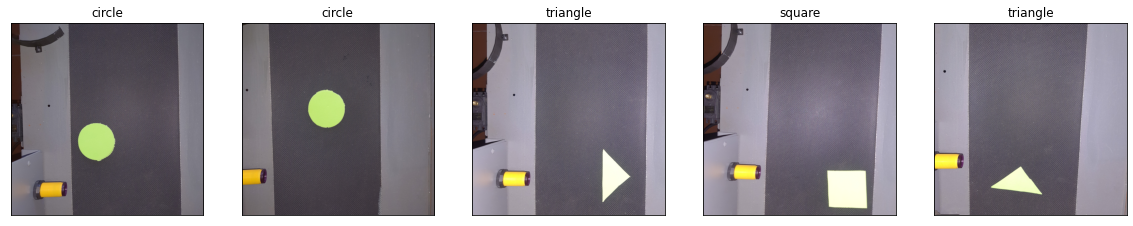

In [5]:
def plot_random_geometric_figures(geometric_figures: List[GeometricFigure], n: int) -> None:
    fig, axs = plt.subplots(1, n, figsize=(20, 20))
    for i in range(n):
        index = np.random.randint(0, len(geometric_figures))
        axs[i].imshow(geometric_figures[index]['image'])
        axs[i].set_title(geometric_figures[index]['category'])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    fig.patch.set_facecolor('white')

plot_random_geometric_figures(geometric_figures, 5)
plt.show()

Verificação dos canais de cor da imagem para identificar o canal de maior importância

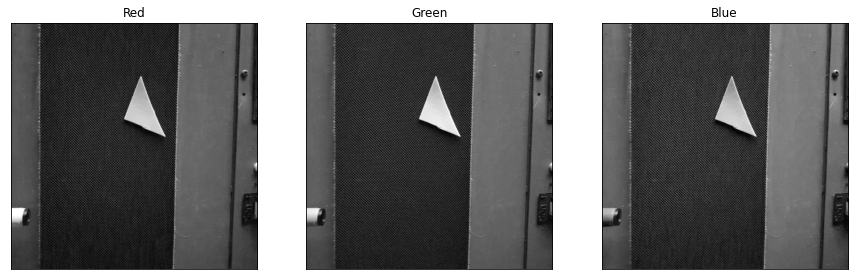

In [6]:
def plot_separate_color_channels_image(image: np.ndarray) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(image[:, :, 0], cmap='gray')
    axs[0].set_title('Red')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(image[:, :, 1], cmap='gray')
    axs[1].set_title('Green')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[2].imshow(image[:, :, 2], cmap='gray')
    axs[2].set_title('Blue')
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    fig.patch.set_facecolor('white')

image = geometric_figures[np.random.randint(0, len(geometric_figures))]['image']
plot_separate_color_channels_image(image)
plt.show()

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=IMAGE_SIZE),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               33554560  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 33,564,995
Trainable params: 33,564,995
Non-trainable params: 0
_________________________________________________________________


In [23]:
def get_input_and_output(geometric_figure: List[GeometricFigure]) -> Tuple[np.ndarray, np.ndarray]:
    x = geometric_figure['image'][:, :, 1]
    y = {
        'circle': 0,
        'square': 1,
        'triangle': 2,
    }[geometric_figure['category']]
    return x, y


shuffled_geometric_figures: List[GeometricFigure] = deepcopy(geometric_figures)
np.random.shuffle(shuffled_geometric_figures)

x, y = zip(*[get_input_and_output(gf) for gf in shuffled_geometric_figures])
x = np.array(x)
y = np.array(y)

test_size = int(len(x) * TEST_RATIO)
x_train, x_test = x[:-test_size], x[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]


In [24]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
17/17 [==============================] - 5s 163ms/step - loss: 0.5251 - accuracy: 0.8258
Epoch 2/20
17/17 [==============================] - 3s 179ms/step - loss: 0.4754 - accuracy: 0.83332s - loss:
Epoch 3/20
17/17 [==============================] - 2s 144ms/step - loss: 0.5964 - accuracy: 0.8106
Epoch 4/20
17/17 [==============================] - 2s 134ms/step - loss: 0.2248 - accuracy: 0.9242
Epoch 5/20
17/17 [==============================] - 2s 133ms/step - loss: 0.1438 - accuracy: 0.9470
Epoch 6/20
17/17 [==============================] - 2s 140ms/step - loss: 0.1185 - accuracy: 0.9621
Epoch 7/20
17/17 [==============================] - 2s 131ms/step - loss: 0.1219 - accuracy: 0.9545
Epoch 8/20
17/17 [==============================] - 2s 131ms/step - loss: 0.0946 - accuracy: 0.9773
Epoch 9/20
17/17 [==============================] - 2s 146ms/step - loss: 0.0736 - accuracy: 0.9811
Epoch 10/20
17/17 [==============================] - 2s 137ms/step - loss: 0.0889 - accura

In [25]:
model.evaluate(x_test, y_test)

5/5 [==============================] - 0s 28ms/step - loss: 0.4947 - accuracy: 0.8561


[0.49473369121551514, 0.8560606241226196]

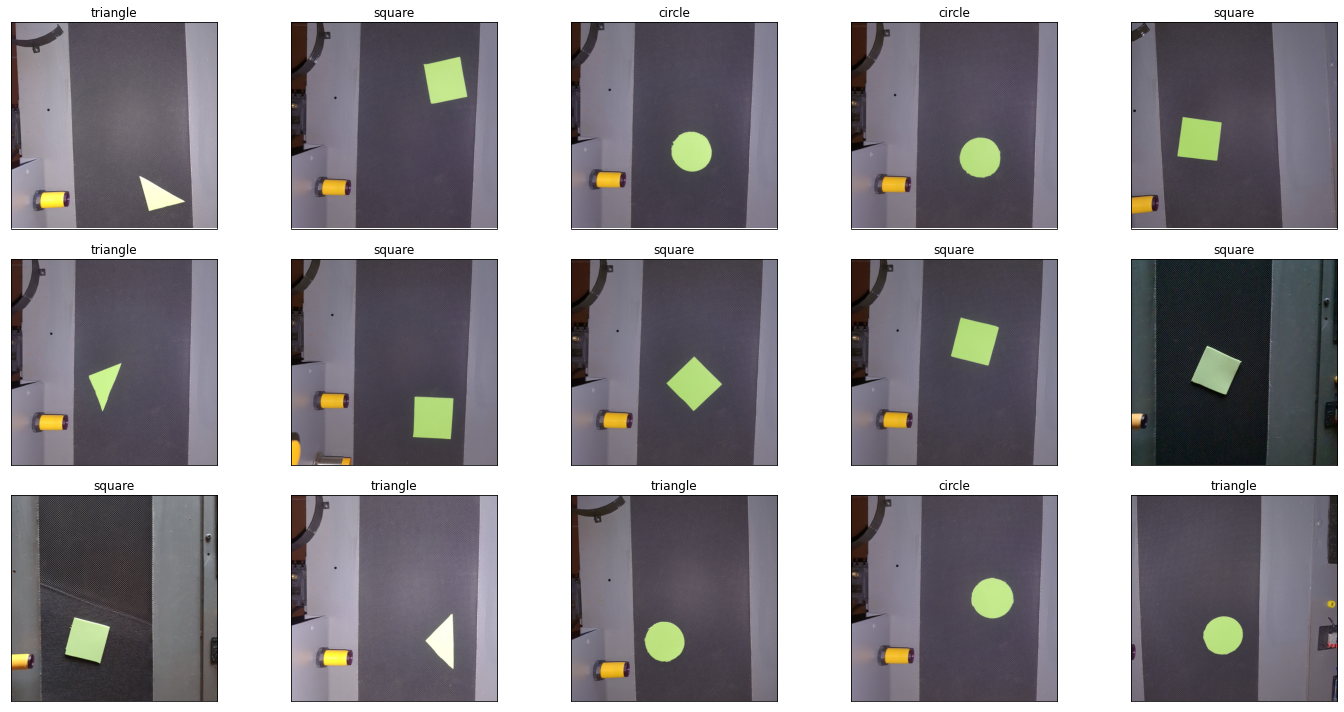

In [26]:
def predict_to_category(y_pred: np.ndarray) -> str:
    category_mapping = {
        0: 'circle',
        1: 'square',
        2: 'triangle',
    }
    return category_mapping[y_pred.argmax()]


rows = 3
columns = 5
random_figures = [geometric_figures[np.random.randint(0, len(geometric_figures))] for _ in range(columns * rows)]
fig, axs = plt.subplots(rows, columns, figsize=(20, 10))
for i in range(rows):
    for j in range(columns):
        random_figure = random_figures[i * columns + j]
        x, y = get_input_and_output(random_figure)
        x = np.expand_dims(x, axis=0)
        y_pred = model.predict(x)
        category = predict_to_category(y_pred)
        axs[i, j].imshow(random_figure['image'])
        axs[i, j].set_title(category)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

In [27]:
model.save('data/geometric_figure_classifier.h5')